In [50]:
from google.cloud import vision
import io
import glob
import os
import os.path
import cv2
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output, Image, display
from io import BytesIO
import PIL.Image
from google.cloud.vision import types
###### before running, please run export GOOGLE_APPLICATION_CREDENTIALS='/path/to/your/client_secret.json'
#export GOOGLE_APPLICATION_CREDENTIALS='/c/Users/poorv/Downloads/ocr_scripts/keys/direct-outlook-270501-c05c2d97d1c6.json'
#echo $GOOGLE_APPLICATION_CREDENTIALS 
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:/Users/poorv/Downloads/ocr_scripts/keys/direct-outlook-270501-c05c2d97d1c6.json"

In [55]:
def pgn(pg_num):
    return "pngs/output-{}-to-{}.png".format(pg_num, pg_num)

In [56]:
def di(*args):
    fig2 = plt.figure(figsize = (15,10))
    num_args = len(*args)
    imgs = args[0]
    if num_args == 1:
        plt.subplot(111)
        plt.imshow(imgs[0],cmap = 'gray')
        plt.show()
    elif num_args == 2:
        plt.subplot(121)
        plt.imshow(imgs[0],cmap = 'gray')
        plt.subplot(122)
        plt.imshow(imgs[1],cmap = 'gray')
        plt.show()
    else:
        #i.e. 3 images
        plt.subplot(131)
        plt.imshow(imgs[0],cmap = 'gray')
        plt.subplot(132)
        plt.imshow(imgs[1],cmap = 'gray')
        plt.subplot(133)
        plt.imshow(imgs[2],cmap = 'gray')
        plt.show()

def d1(im, h=15, w=15):
    fig1 = plt.figure(figsize = (h,w))
    plt.subplot(111)
    plt.imshow(im)
    plt.show()

In [71]:
def split(pg_num):
#     pg_img = "b_jpgs/output-{}-to-{}.jpg".format(pg_num, pg_num)
    pg_img = pgn(pg_num)
#     os.path.isfile(pg_img)
    tc = cv2.imread(pg_img) 
    height, width, channels = tc.shape
    
    im = tc.copy()
    im_gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(im_gray,127,255,cv2.THRESH_BINARY_INV)
    thresh = cv2.GaussianBlur(thresh,(1, 1),0)
    edges = cv2.Canny(thresh,50,100,apertureSize = 3)

    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 1  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 1  # minimum number of pixels making up a line
    max_line_gap = 1200  # maximum gap in pixels between connectable line segments
    # line_image = np.copy(img) * 0  # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)

    vert_line = []
    vert_avg = 0
    center = width / 2
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(thresh,(x1,y1),(x2,y2),(255,0,0),15)
            if x1 == x2:
                vert_avg+=x1
                vert_line.append(line)
    
    struct = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
    thresh = cv2.dilate(thresh, struct, anchor=(-1, -1), iterations=120)

    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    minArea=2000 #nothing 
    for cnt in contours:
        area=cv2.contourArea(cnt)
        if(area>minArea):
            rect = cv2.minAreaRect(cnt)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            cv2.drawContours(im,[box],0,(0,0,255),1)

    # imgs = (edges, thresh, im)
#     imgs = (thresh, tc)
    av = int(vert_avg/len(vert_line))
    thickness = int(av*0.0038)
    cv2.line(tc,(av,0),(av,height),(255,0,0),thickness)
#     di(imgs)
    d1(tc, h = 12, w = 12)
    print(av)
    return (pg_img, av)

In [ ]:
# tc = cv2.imread(imt[0])
imt = split(147)
# imt[0]
# for i in range(160, 170):
#     print(i,"\n")
#     imt = split(i)

In [ ]:
d1(im, h = 30, w = 30)

pngs/output-188-to-188.png


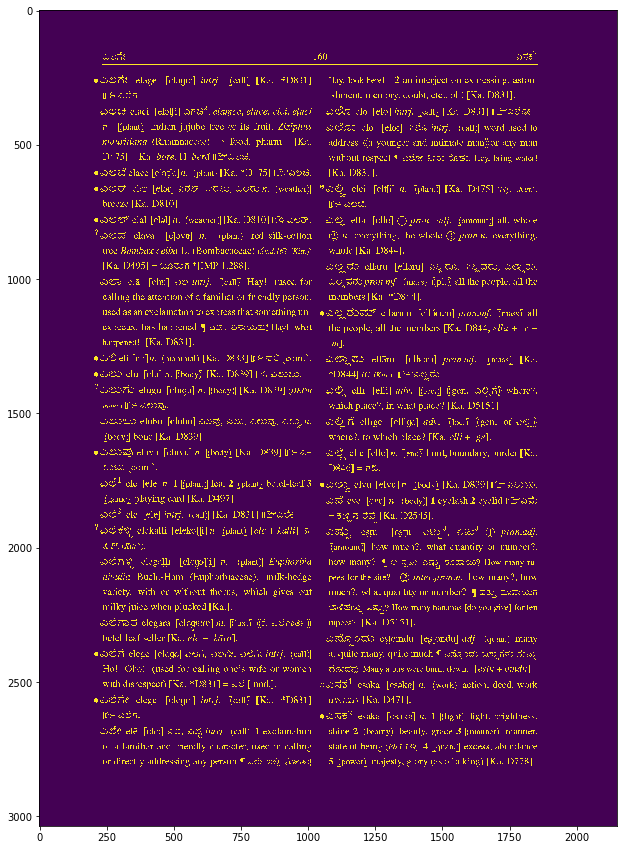

(3036, 2150)

In [69]:
print(pgn(188))
im = cv2.imread(pgn(188))
im_gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(im_gray,127,255,cv2.THRESH_BINARY_INV)
# thresh = cv2.threshold(im_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
d1(thresh)
thresh.shape

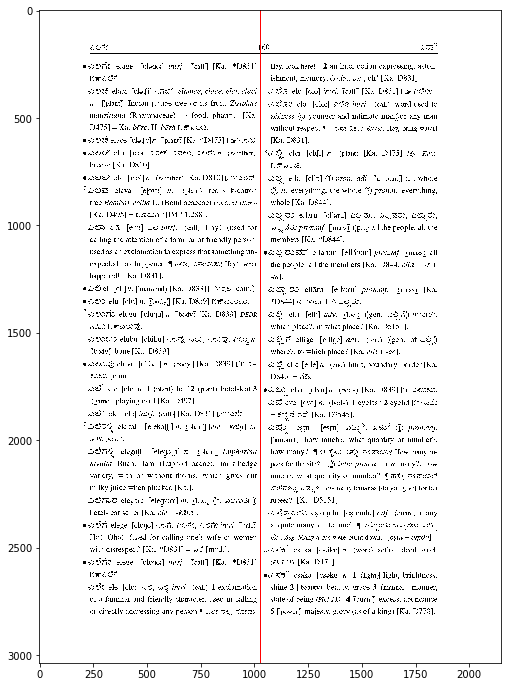

1032


In [72]:
imt = split(188) #fm 147
av1 = imt[1]

In [73]:
def rl(ic, av):
#     ic = cv2.imread(imt[0])
#     av = imt[1]
    height, width = ic.shape
    right = ic[0:height, av:width] #this line crops\n",
    left = ic[0:height, 0:av]
    rl = (left, right)
    di(rl)
    return rl

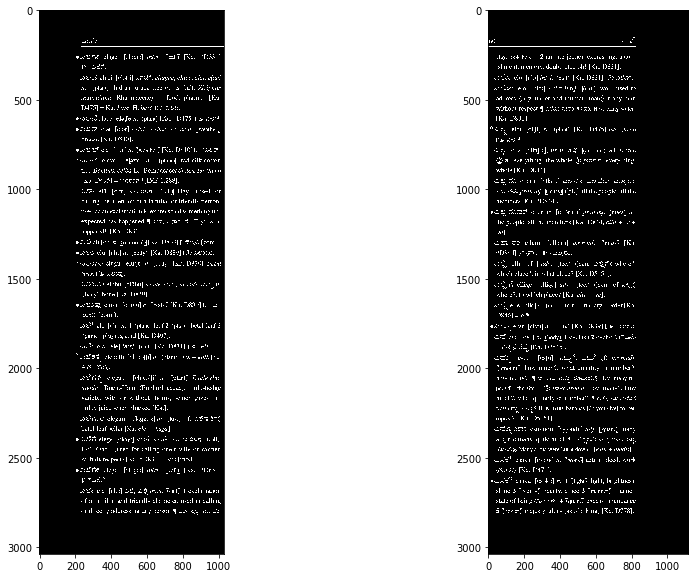

In [74]:
tlr = rl(thresh, av1)

In [68]:
dtlh(tlr[0], ["kn"])

ಎಲಗೇ
"ಎಲಗೇ elage [elages] intrj, call) [Ka. *D831]
[ ಎಲೆಗೆ.
ಎಲಚಿ elaci [clagi] ಎಗಚಿ, eldgLCe, elace, elci, eloci
18. (plant} Indian jujube tree or its fruit, ZiziphUS
17QUAritiurna (Rharmnaceae) - food, pharm. [Ka.
D475] = Ka. bore, H.bert [ಎಲಚಿ.
•ಎಲಚೆ ಅlace [elage]. (plant) [Ka. *D475] [೯ ಎಲಚಿ.
(ಎಲರ್‌ ಅlar [elor] ಎರಲ್, ಎರಲು, ಎಲರು 11. (weather)
breeze [Ka. D810].
•ಎಲಲ್ elal [elal] . (weather] [Ka. D810] [ಕ ಎಲ‌ .
* ಎಲವ elava [elove] 11. planty red silk-cotton
tree Bombax Ceiba L. (Bombacaceae) (Smtd.16? (Kit.)
[Ka. D495] = ಬೂರುಗ *[IMP 1.288].
ಎಲಾ ela [eler] ಎಲ intrj. [cally Hay! (used for
calling the attention of a familiar or friendly person,
used as an exclamation to express that something un-
expected has happened ಎಲಾ, ಏನಾಯಿತು! Hay! what
happened! [Ka. 831].
(ಎಲಿ eli [eli]7. [mammal][Ka. D833] [ ಇಲಿ (com.).
•ಎಲು elu [elu] 7. [body) [Ka. D839] IFಎಲುಬು.
* ಎಲುಗು elugu [elugu] 1. (body) [Ka. D839] (DEDR
trudex) [ ಎಲುವು.
ಎಲುಬು elubu [elibu] ಎಲವು, ಎಲು, ಎಲುವು, ಎಲ್ಕು 1.
(body] bone [Ka. D839


# OCR

In [ ]:
# you can if a word continues on a another page if the next page starts with an english word

In [44]:
def dtlh(path, lh):
    """Detects text in the file."""
    client = vision.ImageAnnotatorClient()
    if type(path) == str:
        with io.open(path, 'rb') as image_file:
            content = image_file.read()
            image = vision.types.Image(content=content)
    else:
        image = types.Image(content=cv2.imencode('.jpg', path)[1].tostring())
        
    response = client.text_detection(
    image=image,
    image_context={"language_hints": lh},  # Bengali
    )
    texts = response.text_annotations
    print(texts[0].description)
    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
#dtlh(pg188, ["kn"]) string_path example 
#dtlh(left, ["kn"]) cv2 example
#dtlh(pgn(188), ["kn"])

In [ ]:
dtlh(left, ["kn"])